# Wasserstein Diffusion Curvature with Manifold Distances

In [1]:
#|default_exp wasserstein
#|include false
from fastcore.all import *
from diffusion_curvature.core import *
from diffusion_curvature.datasets import *
import numpy as np

In the *Diffusion Curvature* Thesis, we introduced two semi-equivalent formulations of diffusion-based curvature. In the first, the Wasserstein-1 distance between a diffusion and a dirac is used as our measure of the spread of diffusion. In the second, this quantity is replaced by the entropy of the diffusion, a surgery which theoretically corresponds to substituting the KL Divergence for the Wasserstein distance.

The entropic formulation of diffusion curvature is faster to compute, but the Wasserstein one has better ties to theory. And, because it only requires transport distances between a distribution and a dirac, all it needs are manifold distances. 

In this notebook, we implement and evaluate this wasserstein diffusion curvature, comparing various methods of deriving manifold distances. Specifically, we'll compare:
1. PHATE distances
2. Heat Geodesic Distances

In [2]:
#|export
def wasserstein_spread_of_diffusion_matrix(
    P, # Diffusion matrix
    D, # Distance matrix
):
    w1_spread_of_diff = np.sum(P*D,axis=1)
    return w1_spread_of_diff    

In [3]:
D = np.random.rand(4,4)
P = np.random.rand(4,4)
assert wasserstein_spread_of_diffusion_matrix(P,D)[0] == (P[0]*D[0]).sum()

In [4]:
#|export
import phate
from sklearn.metrics import pairwise_distances

def get_manifold_distances(
    method:str = "PHATE", # Choices: PHATE
    manifold_dim:int = 2, # intrinsic dimension of data
    X:np.ndarray=None, # Points, if available
    A:np.ndarray=None, # affinity graph, if available
    k:int=10, # num neighbors when constructing binary graph for shortest paths
):
    match method:
        case "PHATE":
            phate_op = phate.PHATE(n_components=manifold_dim)
            phate_coords = phate_op.fit_transform(X)
            D = pairwise_distances(phate_coords)
        case "shortest path":
            import networkx as nx
            from sklearn.neighbors import NearestNeighbors
            knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
            knn.fit(X)
            A = knn.kneighbors_graph()
            G_nx = nx.from_numpy_array(A)
            D = nx.floyd_warshall_numpy(G_nx)
        case _:
            raise NotImplementedError(f"Unknown manifold distance method {method}")
    return D

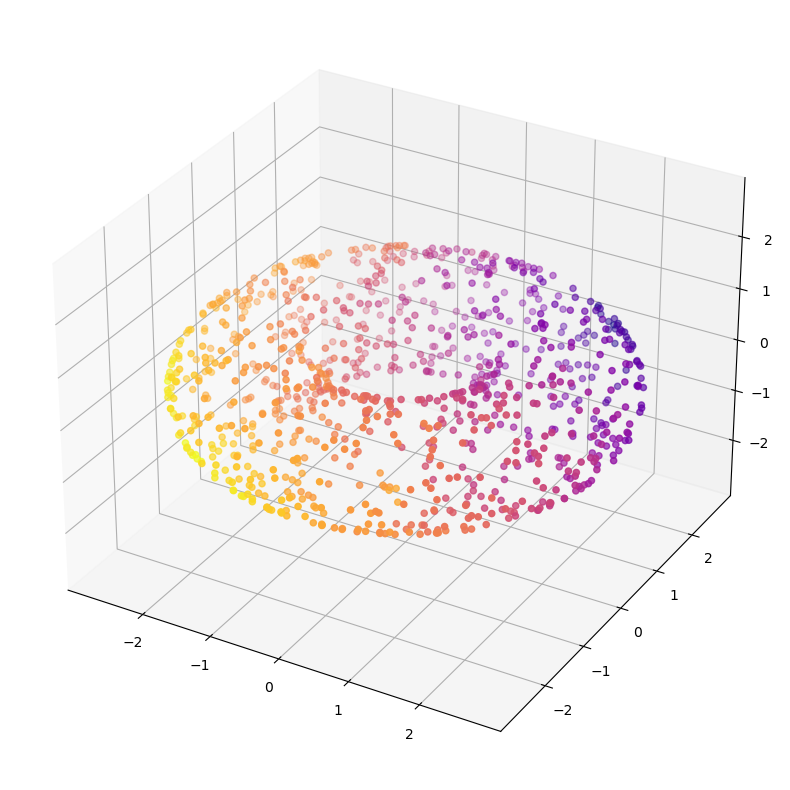

In [5]:
X,ks = torus(2000)
D = get_manifold_distances(method="shortest path",X=X)
plot_3d(X,D[0])

In [29]:
#|export
from diffusion_curvature.datasets import *
class WassersteinDiffusionCurvature(): #TODO: Factor out some of this into a superclass that can share code & functionality with the entropic dc
    def __init__(self,
        t=8,
        k=10, # nearest neighbor parameter for kernel
        manifold_distance_method="PHATE",
        curvature_type="comparison",
        manifold_dimension="auto", # if auto, estimates with skdim DANCo. 
        average_curvature=False,
    ):
        store_attr()
        
    def curvature_of_points(self,
        X:np.ndarray, # pointcloud
        num_holes:int=None, # if using gauss bonnet method, must specify
    ):
        self.X = X
        self.A = gaussian_kernel(X, kernel_type="adaptive",k=self.k)
        return self.curvature_of_graph(num_holes=num_holes)
        
    def curvature_of_graph(self,
        A:np.ndarray=None,
        num_holes:int=None, # if using gauss bonnet method, must specify
    ):
        if A: self.A = A
        self.P = compute_anisotropic_diffusion_matrix_from_graph(self.A, alpha=1)
        self.Pt = np.linalg.matrix_power(self.P,self.t)
        self.D = get_manifold_distances(X=self.X, A=self.A, method=self.manifold_distance_method, k=self.k)
        self.wasserstein_spreads = wasserstein_spread_of_diffusion_matrix(self.Pt,self.D)
        if self.average_curvature:
            self.wasserstein_spreads = self.P @ self.wasserstein_spreads
        match self.curvature_type:
            case "ollivier":
                self.jumps = wasserstein_spread_of_diffusion_matrix(self.P,self.D)
                self.ks = 1 - self.wasserstein_spreads/(self.t * self.jumps)
            case "comparison":
                if self.manifold_dimension == "auto":
                    import skdim
                    danco = skdim.id.DANCo().fit(self.X)
                    self.manifold_dimension = danco.dimension_
                # TODO: Could reduce this boilerplate by instantiating the class inside of itself!
                X_comp = np.vstack([np.zeros(self.manifold_dimension),2*np.random.rand(len(self.A)-1,self.manifold_dimension)-1])
                A_comp = gaussian_kernel(X_comp, kernel_type="adaptive",k=self.k)
                P_comp = compute_anisotropic_diffusion_matrix_from_graph(A_comp, alpha=1)
                Pt_comp = np.linalg.matrix_power(P_comp,self.t)        
                D_comp = get_manifold_distances(X=X_comp, A=A_comp, method=self.manifold_distance_method, k = self.k)
                wasserstein_spreads_comp = np.sum(Pt_comp[0]*D_comp[0])
                # compute difference
                self.ks = wasserstein_spreads_comp - self.wasserstein_spreads
            case "gauss bonnet":
                euler_char = 2 - 2*num_holes
                c = (np.sum(1/self.wasserstein_spreads) - 2*np.pi*euler_char)/(len(self.wasserstein_spreads))
                self.ks = 1/self.wasserstein_spreads - c
            case _:
                raise NotImplementedError
        return self.ks
    
    def plot(self):
        plot_3d(X,self.ks,colorbar=True)
        

# Experiments

## With PHATE Distances (untuned)

The comparison method:

In [22]:
X, ks = torus(2000)
Wk_comp = WassersteinDiffusionCurvature(k=10,manifold_distance_method="PHATE",curvature_type="comparison",manifold_dimension=2)
_ = Wk_comp.curvature_of_points(X)

Calculating PHATE...
  Running PHATE on 1001 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 1.19 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.22 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.52 seconds.
Calculated PHATE in 1.98 seconds.
Calculating PHATE...
  Running PHATE on 1002 observations and 2 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 1.23 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.19 seconds

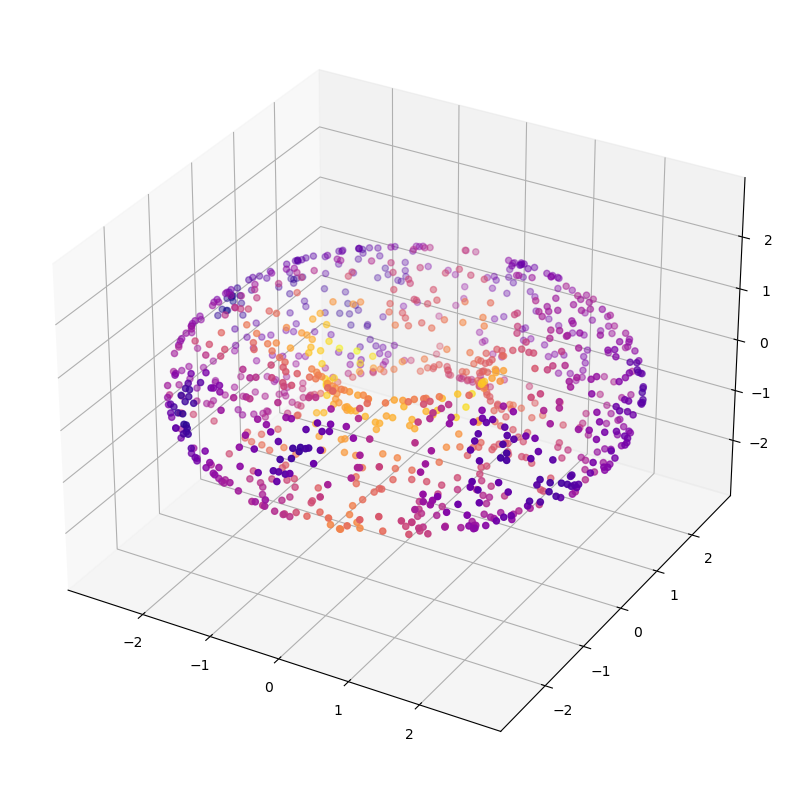

In [23]:
plot_3d(X,Wk_comp.wasserstein_spreads)

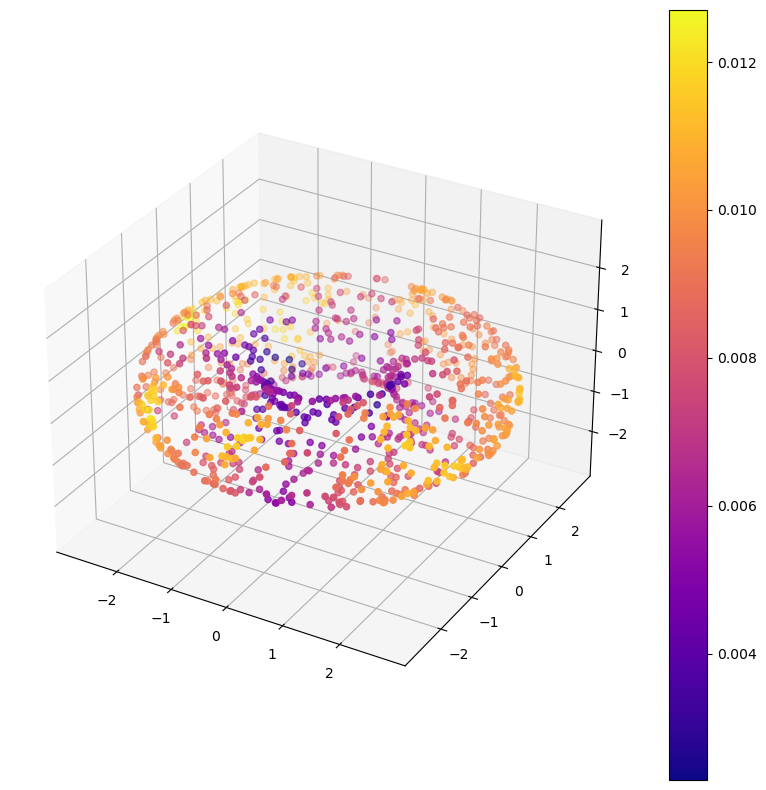

In [24]:
Wk_comp.plot()

The Ollivier-style method:

In [10]:
X, ks = torus(2000)
Wk_oll = WassersteinDiffusionCurvature(k=10,manifold_distance_method="PHATE",curvature_type="ollivier",manifold_dimension=2)
_ = Wk_oll.curvature_of_points(X)

Calculating PHATE...
  Running PHATE on 1017 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 1.21 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.24 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.51 seconds.
Calculated PHATE in 2.03 seconds.


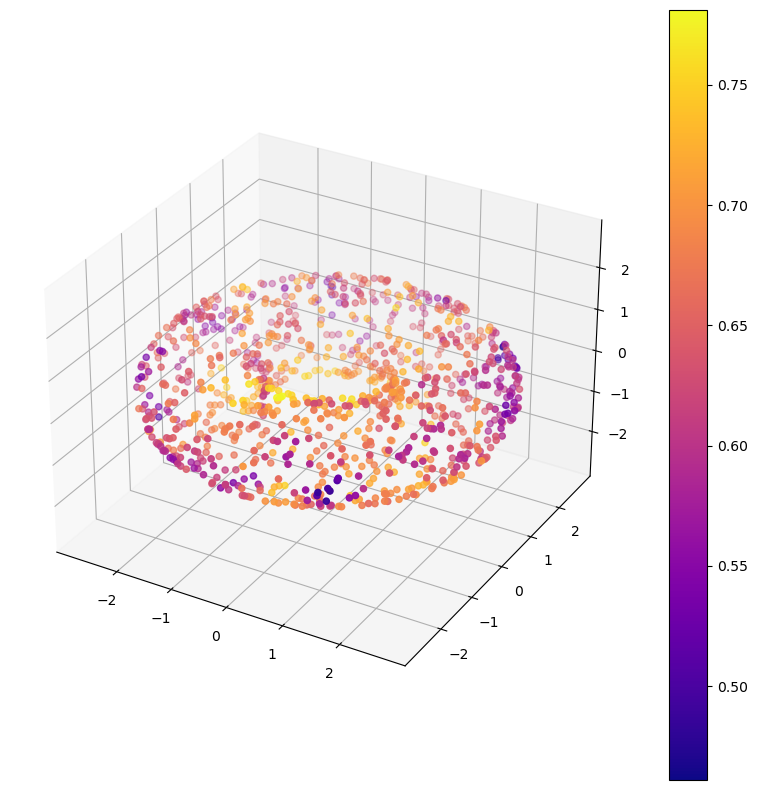

In [11]:
Wk_oll.plot()

The Gauss-Bonnet Method:

In [34]:
X, ks = torus(3000)
Wk_gauss = WassersteinDiffusionCurvature(k=10,manifold_distance_method="PHATE",curvature_type="gauss bonnet",manifold_dimension=2, average_curvature=True)
_ = Wk_gauss.curvature_of_points(X, num_holes=1)

Calculating PHATE...
  Running PHATE on 1508 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 2.33 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.44 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.33 seconds.
Calculated PHATE in 4.14 seconds.


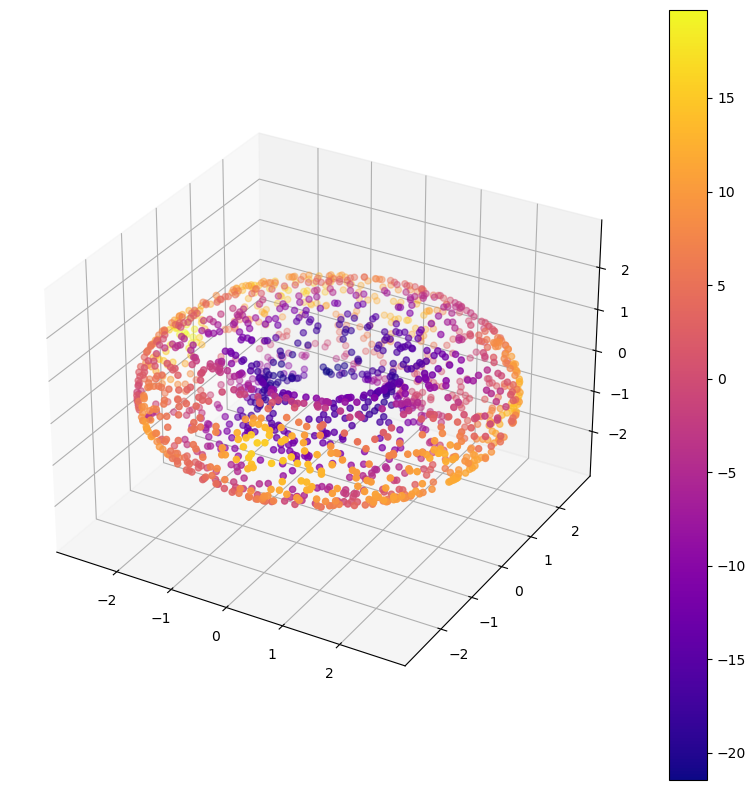

In [35]:
Wk_gauss.plot()

## With Shortest Path Distances

In [17]:
X, ks = torus(2000)
Wk_comp = WassersteinDiffusionCurvature(k=10,manifold_distance_method="shortest path",curvature_type="comparison",manifold_dimension=2)
_ = Wk_comp.curvature_of_points(X)

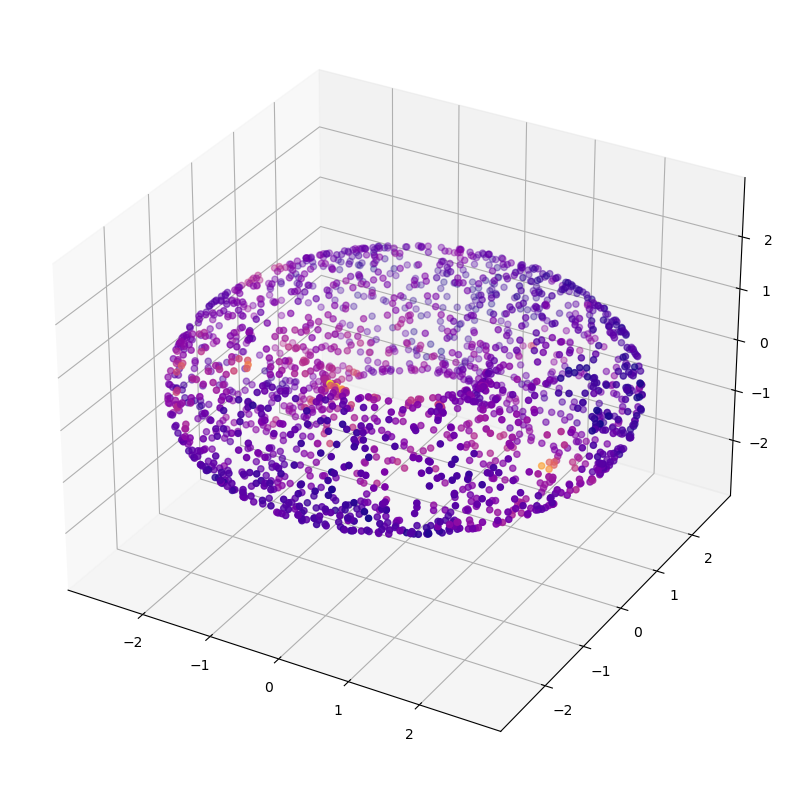

In [18]:
plot_3d(X,Wk_comp.wasserstein_spreads)

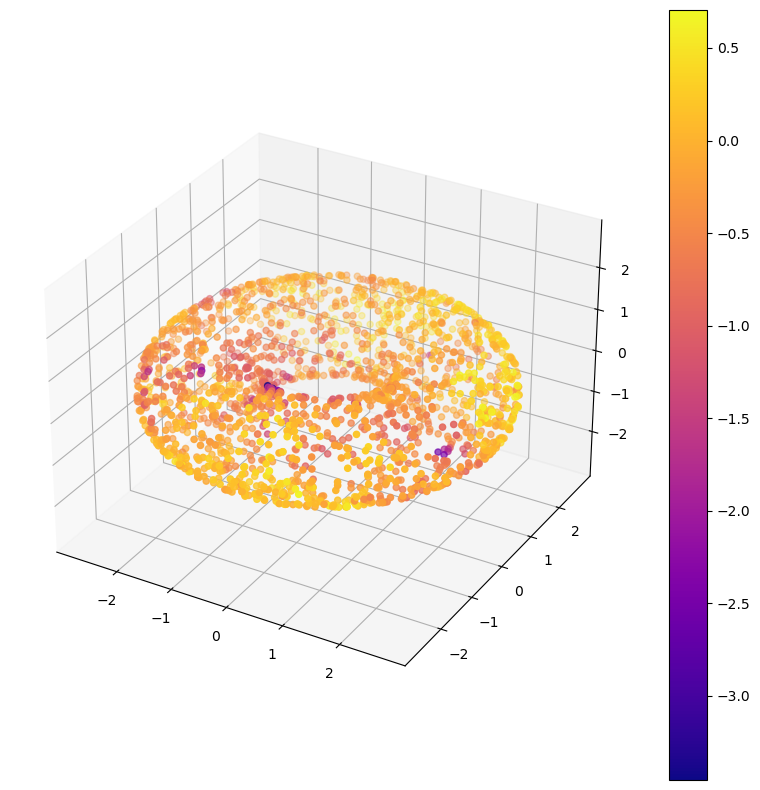

In [19]:
Wk_comp.plot()

In [15]:
X, ks = torus(2000)
Wk_oll = WassersteinDiffusionCurvature(k=10,manifold_distance_method="shortest path",curvature_type="ollivier",manifold_dimension=2)
_ = Wk_oll.curvature_of_points(X)

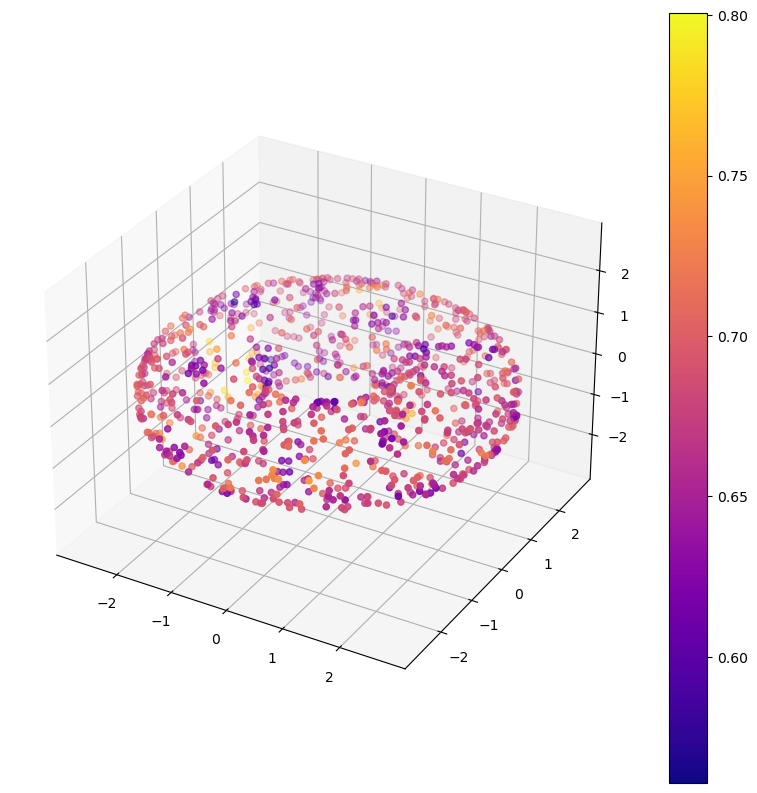

In [16]:
Wk_oll.plot()